In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
sns.set()

from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [2]:
frame = pd.read_csv('for_data_science_newline_fixed.csv', usecols = ["IN FILE","CLIP LENGTH","OFFSET","DURATION","MAX FREQ","MIN FREQ","SAMPLE RATE","LAST MOD BY"])
# frame.head(10)

In [3]:
CLIP_LENGTHS = frame.groupby("IN FILE")[["CLIP LENGTH"]].max()
SUM_DURATIONS = frame.groupby("IN FILE")[["DURATION"]].sum()

MEDIAN_DURATIONS = frame.groupby("IN FILE")[["DURATION"]].median()
MEDIAN_DURATIONS = MEDIAN_DURATIONS.rename(columns={'DURATION': 'MEDIAN DURATION'})

NUMBER_ANN = frame.groupby("IN FILE")[["OFFSET"]].count()
NUMBER_ANN = NUMBER_ANN.rename(columns = {'OFFSET':'OFFSET COUNT'})

MED_DIST_BW_ANNS = frame.copy(True)

MED_DIST_BW_ANNS = MED_DIST_BW_ANNS.sort_values(['IN FILE','OFFSET'])
MED_DIST_BW_ANNS['ENDSET'] = MED_DIST_BW_ANNS['OFFSET'] + MED_DIST_BW_ANNS['DURATION']

MED_DIST_BW_ANNS = MED_DIST_BW_ANNS[['IN FILE','CLIP LENGTH','OFFSET','ENDSET','LAST MOD BY']]

MED_DIST_BW_ANNS['PREV END'] = MED_DIST_BW_ANNS.loc[MED_DIST_BW_ANNS['IN FILE'].shift(-1) == MED_DIST_BW_ANNS['IN FILE'], 'ENDSET']
MED_DIST_BW_ANNS['PREV END'] = MED_DIST_BW_ANNS['PREV END'].shift()

MED_DIST_BW_ANNS = MED_DIST_BW_ANNS.fillna(0)
MED_DIST_BW_ANNS['DIST BETWEEN ANN PREV'] = MED_DIST_BW_ANNS['OFFSET'] - MED_DIST_BW_ANNS['PREV END']

MED_DIST_BW_ANNS['OVERLAP'] = MED_DIST_BW_ANNS['DIST BETWEEN ANN PREV'].loc[MED_DIST_BW_ANNS['DIST BETWEEN ANN PREV'] < 0]

OVER_LAP = MED_DIST_BW_ANNS.groupby('IN FILE')[['OVERLAP']].count()
OVER_LAP = OVER_LAP.rename(columns = {'OVERLAP':'OVERLAP COUNT'})

DIST_BETWEEN_ANN_PREV = MED_DIST_BW_ANNS.groupby('IN FILE')[['DIST BETWEEN ANN PREV']].median()
DIST_BETWEEN_ANN_PREV = DIST_BETWEEN_ANN_PREV.rename(columns={'DIST BETWEEN ANN PREV': 'MEDIAN DIST B/W ANNS'})

LAST_MOD_BY = MED_DIST_BW_ANNS.groupby('IN FILE')[['LAST MOD BY']].max()

WHITE_SPACE = frame.copy(True)
DUR = WHITE_SPACE.groupby(['IN FILE'])[['DURATION']].sum()
DUR = DUR.rename(columns = {'DURATION':'SUM DURATION'})
LEN = WHITE_SPACE.groupby(['IN FILE'])[['CLIP LENGTH']].max()
WHITE_SPACE = LEN.join(DUR)
WHITE_SPACE['WHITE SPACE'] = WHITE_SPACE['CLIP LENGTH'] - WHITE_SPACE['SUM DURATION']

WHITE_SPACE = WHITE_SPACE.join(OVER_LAP)
WHITE_SPACE = WHITE_SPACE.join(DIST_BETWEEN_ANN_PREV)
WHITE_SPACE = WHITE_SPACE.join(MEDIAN_DURATIONS)
WHITE_SPACE = WHITE_SPACE.join(NUMBER_ANN)
WHITE_SPACE = WHITE_SPACE.join(LAST_MOD_BY)
WHITE_SPACE.reset_index(inplace=True)
# WHITE_SPACE.head(10)
# MED_DIST_BW_ANNS

In [4]:
def species(row):
    species = row['IN FILE']
    spec = species.split('-')
    spec_to = '-'.join(spec[:-2])
    return spec_to

WHITE_SPACE['GENUS'] = WHITE_SPACE.apply(lambda row: species(row), axis=1)
len(WHITE_SPACE['GENUS'].unique())
# WHITE_SPACE.head(10)

515

In [5]:
# # resample if sampled is admin user
# annotator = WHITE_SPACE['LAST MOD BY'].unique()
# sampled_annotator = ['EdZamora'] #random.sample(list(annotator),1) #['kkong', 'JacobGlennAyers']  
# # ['EdZamora'], ['kkong', 'sunqiaochen'], ['kkong', 'JacobGlennAyers'], ['kushagra1067', 'EdZamora'], ['hjagarla', 'alarce'], ['dnelson', 'sunqiaochen'], ['sunqiaochen', 'j4yang'](not gud), ['dnelson', 'hjagarla']
# # ['weszhen', 'JacobGlennAyers', 'dnelson']
# sampled_annotator 

In [6]:
annotator = WHITE_SPACE['LAST MOD BY'].unique()
sampled_annotator = ['EdZamora','kkong'] #random.sample(list(annotator),1)
print(sampled_annotator)

annotator_df = WHITE_SPACE[WHITE_SPACE['LAST MOD BY'].isin(sampled_annotator)]

genus_counts = annotator_df['GENUS'].value_counts()
sampled_genus = genus_counts.index[:5]#random.sample(list(genus)counts),1)
print(sampled_genus)

# genus = annotator_df[['LAST MOD BY','GENUS']].groupby(['GENUS','LAST MOD BY'])[['LAST MOD BY']].count().rename(columns = {"LAST MOD BY":'COUNT'}).reset_index()
# genus['LAST MOD BY'] = (genus['LAST MOD BY']+' '+genus['COUNT'].astype(str))
# genus = genus.drop(columns = ['COUNT']).groupby('GENUS')['LAST MOD BY'].apply(list).to_dict()
# shared_genus_anns = [i for i in genus if len(genus.get(i)) == 2]
# print(shared_genus_anns)

WHITE_SPACE = annotator_df[annotator_df['GENUS'].isin(sampled_genus)] # shared_genus_anns
WHITE_SPACE.head()

['EdZamora', 'kkong']
Index(['Tangara', 'Psarocolius', 'Schiffornis', 'Saltator', 'Euphonia'], dtype='object')


,IN FILE,CLIP LENGTH,SUM DURATION,WHITE SPACE,OVERLAP COUNT,MEDIAN DIST B/W ANNS,MEDIAN DURATION,OFFSET COUNT,LAST MOD BY,GENUS
788,Euphonia-chlorotica-264822.wav,27.7420,15.9111,11.8309,2,0.180,0.56505,24,EdZamora,Euphonia
789,Euphonia-chlorotica-392016.wav,42.8880,20.7294,22.1586,9,0.190,0.33000,53,EdZamora,Euphonia
791,Euphonia-chrysopasta-171246.wav,113.1600,29.9445,83.2155,0,4.665,1.46000,18,kkong,Euphonia
793,Euphonia-cyanocephala-275607.wav,17.0841,11.0761,6.0080,0,1.445,4.13860,3,kkong,Euphonia
798,Euphonia-laniirostris-45661.wav,30.4849,27.9454,2.5395,48,-0.020,0.42495,58,EdZamora,Euphonia


In [7]:
X = WHITE_SPACE.drop(columns = ['IN FILE','GENUS','LAST MOD BY']) # expand to taxa rather than species

Y = np.array(WHITE_SPACE['GENUS'])
Y_2 = np.array(WHITE_SPACE['LAST MOD BY'])
Y_3 = np.array(WHITE_SPACE['IN FILE'])

In [8]:
scaler = StandardScaler()
X_std = scaler.fit_transform(X)
X_std

array([[-5.13176831e-01,  1.43237709e-02, -5.69571367e-01,
         8.54635864e-02, -8.03878842e-01, -9.50575313e-01,
         9.04773535e-01],
       [-1.13182164e-01,  3.98452788e-01, -2.69624834e-01,
         1.09629152e+00, -8.01263583e-01, -1.21184651e+00,
         3.24663727e+00],
       [ 1.74264942e+00,  1.13310761e+00,  1.50364565e+00,
        -2.03344395e-01,  3.69064815e-01,  4.42115655e-02,
         4.20250002e-01],
       [-7.94644094e-01, -3.71136619e-01, -7.38685369e-01,
        -2.03344395e-01, -4.73048580e-01,  3.02162498e+00,
        -7.91058828e-01],
       [-4.40738869e-01,  9.73733486e-01, -8.39420726e-01,
         6.72804716e+00, -8.56184021e-01, -1.10630428e+00,
         3.65040688e+00],
       [ 3.88805068e-01,  1.33585897e+00, -5.90723982e-02,
        -2.03344395e-01, -7.77726252e-01, -1.23407762e+00,
         3.08512943e+00],
       [-7.81230830e-01, -8.53101622e-01, -5.48355517e-01,
        -2.03344395e-01,  6.96861376e-01,  1.21723642e+00,
        -8.7181275

In [9]:
tsne = TSNE(n_components=3, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(X_std) 

tsneed = pd.DataFrame(tsne_results, columns = ['TSNE1','TSNE2','TSNE3']) # ,'TSNE4','TSNE5','TSNE6'
tsneed

C:\Users\lianl\anaconda3\envs\tweety\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\lianl\anaconda3\envs\tweety\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 48 nearest neighbors...
[t-SNE] Indexed 49 samples in 0.000s...
[t-SNE] Computed neighbors for 49 samples in 0.007s...
[t-SNE] Computed conditional probabilities for sample 49 / 49
[t-SNE] Mean sigma: 3.226858
[t-SNE] KL divergence after 250 iterations with early exaggeration: 82.035881
[t-SNE] KL divergence after 300 iterations: 1.099998


,TSNE1,TSNE2,TSNE3
0,-2.430069,-54.318878,-20.997787
1,-14.617945,-31.415937,-33.224010
2,-7.414075,27.425514,8.707233
3,-6.623138,-13.600827,11.054681
4,14.856796,-31.604530,21.588289
5,-1.923040,8.052958,26.414648
6,-29.771717,-4.663214,-4.026187
7,38.007084,-39.208954,20.209974
8,-9.427572,-4.387982,-50.645432
9,-2.219666,6.523316,-1.486369


In [10]:
wcss = []
for i in range(1,21):
    kmeans_iqr = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans_iqr.fit(tsne_results)
    wcss.append(kmeans_iqr.inertia_)

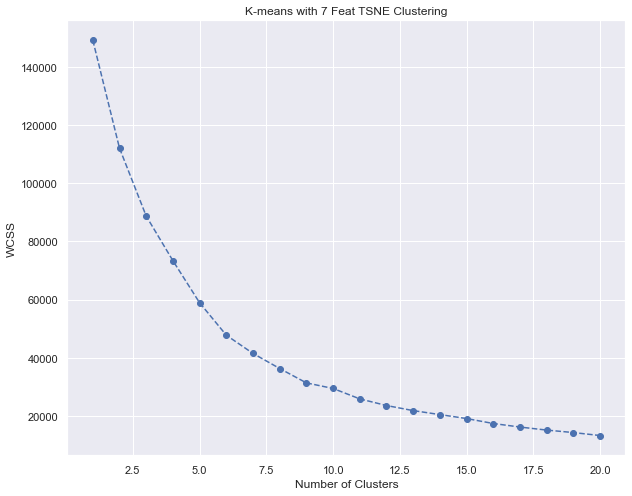

In [11]:
plt.figure(figsize = (10,8))
plt.plot(range(1,21),wcss,marker = 'o', linestyle = '--')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('K-means with 7 Feat TSNE Clustering')
plt.show()

In [12]:
kmeans_iqr = KMeans(n_clusters = 5, init = 'k-means++',random_state = 42)
kmeans_iqr.fit(tsne_results)

KMeans(n_clusters=5, random_state=42)

In [13]:
df_segm_iqr_kmeans = pd.concat([X.reset_index(drop = True), pd.DataFrame(tsne_results,columns = tsneed.columns)], axis = 1)

df_segm_iqr_kmeans['Segment K-means IQR'] = kmeans_iqr.labels_
df_segm_iqr_kmeans['Cluster'] = df_segm_iqr_kmeans['Segment K-means IQR'].map({0:'first',1:'second',2:'third',3:'fourth',4:'fifth'})
df_segm_iqr_kmeans['IN FILE'],df_segm_iqr_kmeans['LAST MOD BY'], df_segm_iqr_kmeans['Genus'] = Y_3,Y_2, Y

In [17]:
df_segm_iqr_kmeans.head()

,CLIP LENGTH,SUM DURATION,WHITE SPACE,OVERLAP COUNT,MEDIAN DIST B/W ANNS,MEDIAN DURATION,OFFSET COUNT,TSNE1,TSNE2,TSNE3,Segment K-means IQR,Cluster,IN FILE,LAST MOD BY,Genus
0,27.7420,15.9111,11.8309,2,0.180,0.56505,24,-2.430069,-54.318878,-20.997787,4,fifth,Euphonia-chlorotica-264822.wav,EdZamora,Euphonia
1,42.8880,20.7294,22.1586,9,0.190,0.33000,53,-14.617945,-31.415937,-33.224010,4,fifth,Euphonia-chlorotica-392016.wav,EdZamora,Euphonia
2,113.1600,29.9445,83.2155,0,4.665,1.46000,18,-7.414075,27.425514,8.707233,0,first,Euphonia-chrysopasta-171246.wav,kkong,Euphonia
3,17.0841,11.0761,6.0080,0,1.445,4.13860,3,-6.623138,-13.600827,11.054681,2,third,Euphonia-cyanocephala-275607.wav,kkong,Euphonia
4,30.4849,27.9454,2.5395,48,-0.020,0.42495,58,14.856796,-31.604530,21.588289,2,third,Euphonia-laniirostris-45661.wav,EdZamora,Euphonia


In [15]:
import plotly.express as px 
import plotly.graph_objects as go
import numpy as np


fig = px.scatter_3d(df_segm_iqr_kmeans, 
                    x='TSNE1',
                    y='TSNE2',
                    z='TSNE3' , 
                    color = df_segm_iqr_kmeans['Cluster'],
                    hover_name = list(tuple(zip(df_segm_iqr_kmeans['IN FILE'],df_segm_iqr_kmeans['LAST MOD BY'])))) 


#color = Y, color_discrete_sequence= px.colors.qualitative.G10)


clust_1 = df_segm_iqr_kmeans[df_segm_iqr_kmeans['Cluster'] == 'first']
x, y, z = clust_1['TSNE1'], clust_1['TSNE2'], clust_1['TSNE3']
fig.add_trace(go.Figure(data=[go.Mesh3d(x=x, y=y, z=z, color='lightblue', opacity=0.50)]).data[0])


clust_2 = df_segm_iqr_kmeans[df_segm_iqr_kmeans['Cluster'] == 'second']
x2, y2, z2 = clust_2['TSNE1'], clust_2['TSNE2'], clust_2['TSNE3']
fig.add_trace(go.Figure(data=[go.Mesh3d(x=x2, y=y2, z=z2, color='lightblue', opacity=0.50)]).data[0])


clust_3 = df_segm_iqr_kmeans[df_segm_iqr_kmeans['Cluster'] == 'third']
x3, y3, z3 = clust_3['TSNE1'], clust_3['TSNE2'], clust_3['TSNE3']
fig.add_trace(go.Figure(data=[go.Mesh3d(x=x3, y=y3, z=z3, color='lightblue', opacity=0.50)]).data[0])


clust_4 = df_segm_iqr_kmeans[df_segm_iqr_kmeans['Cluster'] == 'fourth']
x4, y4, z4 = clust_4['TSNE1'], clust_4['TSNE2'], clust_4['TSNE3']
fig.add_trace(go.Figure(data=[go.Mesh3d(x=x4, y=y4, z=z4, color='lightblue', opacity=0.50)]).data[0])


clust_5 = df_segm_iqr_kmeans[df_segm_iqr_kmeans['Cluster'] == 'fifth']
x5, y5, z5 = clust_5['TSNE1'], clust_5['TSNE2'], clust_5['TSNE3']
fig.add_trace(go.Figure(data=[go.Mesh3d(x=x5, y=y5, z=z5, color='lightblue', opacity=0.50)]).data[0])


fig.update_layout(title_text= (' & '.join(df_segm_iqr_kmeans['LAST MOD BY'].unique()) + ' Annotations'), title_x=0.5)
fig.show()

In [16]:
kaleidoscope_format = pd.read_csv('for_data_science_newline_fixed.csv')
for_kaleidoscope = kaleidoscope_format[kaleidoscope_format['IN FILE'].isin(df_segm_iqr_kmeans['IN FILE'].to_list())] 
for_kaleidoscope

,IN FILE,CLIP LENGTH,OFFSET,DURATION,MAX FREQ,MIN FREQ,SAMPLE RATE,MANUAL ID,TIME_SPENT,LAST MOD BY,LAST MOD DATE,LAST MOD TIME
10032,Euphonia-chlorotica-264822.wav,27.742,0.8974,0.5000,24000,0,44100,Euphonia chlorotica Purple-throated Euphonia,84.003,EdZamora,11/21/2021,15:28:43
10033,Euphonia-chlorotica-264822.wav,27.742,1.7304,0.5601,24000,0,44100,Euphonia chlorotica Purple-throated Euphonia,84.008,EdZamora,11/21/2021,15:28:43
10034,Euphonia-chlorotica-264822.wav,27.742,2.1405,0.4100,24000,0,44100,Euphonia chlorotica Purple-throated Euphonia,84.009,EdZamora,11/21/2021,15:28:43
10035,Euphonia-chlorotica-264822.wav,27.742,4.8907,0.5700,24000,0,44100,Euphonia chlorotica Purple-throated Euphonia,84.011,EdZamora,11/21/2021,15:28:43
10036,Euphonia-chlorotica-264822.wav,27.742,5.4707,0.6001,24000,0,44100,Euphonia chlorotica Purple-throated Euphonia,84.011,EdZamora,11/21/2021,15:28:43
...,...,...,...,...,...,...,...,...,...,...,...,...
27184,Tangara-xanthocephala-45830.wav,23.400,13.9866,0.5300,24000,0,48000,Tangara xanthocephala Saffron-crowned Tanager,28.786,kkong,11/19/2021,04:19:18
27185,Tangara-xanthocephala-45830.wav,23.400,15.8166,0.7500,24000,0,48000,Tangara xanthocephala Saffron-crowned Tanager,28.788,kkong,11/19/2021,04:19:18
27186,Tangara-xanthocephala-45830.wav,23.400,18.4066,0.7200,24000,0,48000,Tangara xanthocephala Saffron-crowned Tanager,28.791,kkong,11/19/2021,04:19:18
27187,Tangara-xanthocephala-45830.wav,23.400,20.4766,0.4900,24000,0,48000,Tangara xanthocephala Saffron-crowned Tanager,28.794,kkong,11/19/2021,04:19:18
